In this Python notebook, K-nearest neighbors and random forest algorithms will be applied to predict app ratings on Google play store.

In [60]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Loading the data
df = pd.read_csv("../app-rating-competition/train.csv")

In [61]:
%matplotlib inline

In [62]:
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

# Data Exploration and Cleaning

In [63]:
def rename_columns(dataframe):
    reformated_df = dataframe.rename(
        columns={"X0": "App", "X1": "Category", "X2": "Reviews", "X3": "Size",
                 "X4": "Installs", "X5": "Type", "X6": "Price", "X7": "Content Rating",
                 "X8": "Genres", "X9": "Last Updated", "X10": "Current Ver",
                 "X11": "Android Ver", "Y": "Rating"})
    return reformated_df

df = rename_columns(df)

df.head()
# Executing the above script will display the first five rows of the dataset as shown below

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Rating
0,Girls hairstyles 2018,BEAUTY,62,3.1M,"10,000+",Free,0,Everyone,Beauty,"May 28, 2018",1.9.2,4.0.3 and up,4.2
1,Dairy Queen,FOOD_AND_DRINK,742,43M,"100,000+",Free,0,Everyone,Food & Drink,"July 25, 2018",2.1.0,4.1 and up,3.6
2,Remote Control For All AC - Universal Remote,PRODUCTIVITY,166,6.1M,"10,000+",Free,0,Everyone,Productivity,"July 28, 2018",1.1,4.0.3 and up,2.4
3,Ultimate Chest Tracker,PRODUCTIVITY,40328,23M,"1,000,000+",Free,0,Everyone,Productivity,"October 17, 2016",1.9,2.3 and up,4.5
4,Mobilight-BM,FINANCE,6,6.2M,500+,Free,0,Everyone,Finance,"August 3, 2018",2.0.10,4.0.3 and up,4.8


In [64]:
# Checking the data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873 entries, 0 to 1872
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1873 non-null   object 
 1   Category        1873 non-null   object 
 2   Reviews         1873 non-null   int64  
 3   Size            1873 non-null   object 
 4   Installs        1873 non-null   object 
 5   Type            1873 non-null   object 
 6   Price           1873 non-null   object 
 7   Content Rating  1873 non-null   object 
 8   Genres          1873 non-null   object 
 9   Last Updated    1873 non-null   object 
 10  Current Ver     1872 non-null   object 
 11  Android Ver     1873 non-null   object 
 12  Rating          1873 non-null   float64
dtypes: float64(1), int64(1), object(11)
memory usage: 190.4+ KB


The dataset has 10,841 records and 13 columns, all of them are object types except the target column (Rating) which is float

App               False
Category          False
Reviews           False
Size              False
Installs          False
Type              False
Price             False
Content Rating    False
Genres            False
Last Updated      False
Current Ver        True
Android Ver       False
Rating            False
dtype: bool

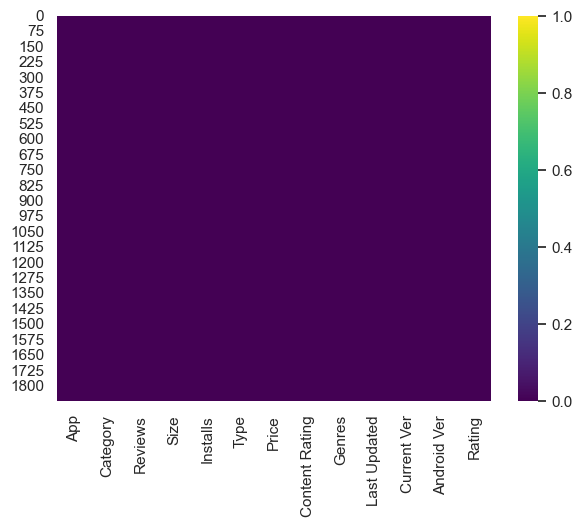

In [65]:
# Exploring missing data and checking if any has NaN values
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
df.isnull().any()

Looks like there are missing values in "Rating", "Type", "Content Rating" and " Android Ver". But most of these missing values in Rating column.

In [66]:
df.isnull().sum()

App               0
Category          0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       1
Android Ver       0
Rating            0
dtype: int64

There are two strategies to handle missing data, either removing records with these missing values or replacing missing values with a specific value like (mean, median or mode) value of the column.

In [67]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [68]:
# Count the number of unique values in category column 
df['Category'].unique()

array(['BEAUTY', 'FOOD_AND_DRINK', 'PRODUCTIVITY', 'FINANCE', 'FAMILY',
       'LIFESTYLE', 'VIDEO_PLAYERS', 'SHOPPING', 'GAME', 'TOOLS',
       'COMMUNICATION', 'EDUCATION', 'BUSINESS', 'COMICS', 'DATING',
       'BOOKS_AND_REFERENCE', 'NEWS_AND_MAGAZINES', 'PARENTING',
       'PERSONALIZATION', 'MEDICAL', 'HEALTH_AND_FITNESS',
       'TRAVEL_AND_LOCAL', 'PHOTOGRAPHY', 'SPORTS', 'LIBRARIES_AND_DEMO',
       'HOUSE_AND_HOME', 'SOCIAL', 'WEATHER', 'EVENTS',
       'AUTO_AND_VEHICLES', 'ENTERTAINMENT', 'ART_AND_DESIGN',
       'MAPS_AND_NAVIGATION'], dtype=object)

In [69]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Rating


It's obvious that the first value of this record is missing (App name) and all other values are respectively propagated backward starting from "Category" towards the "Current Ver"; and the last column which is "Android Ver" is left null. It's better to drop the entire recored instead of consider these unreasonable values while cleaning each column!


In [70]:
# Drop this bad column
df = df.drop(i)

In [71]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

# Categorical Data Encoding¶

Many machine learning algorithms can support categorical values without further manipulation but there are many more algorithms that do not. We need to make all data ready for the model, so we will convert categorical variables (variables that stored as text values) into numircal variables.

In [72]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [73]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [74]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [75]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [76]:
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [77]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [78]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'], drop_first=True)

The above line drops the reference column and just keeps only one of the two columns as retaining this extra column does not add any new information for the modeling process, this line is exactly the same as setting drop_first parameter to True.

In [79]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [80]:
# Convert kbytes to Mbytes 
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter

This can be done by selecting all k values from the "Size" column and replace those values by their corresponding M values, and since k indices belong to a list of non-consecutive numbers, a new dataframe (converter) will be created with these k indices to perform the conversion, then the final values will be assigned back to the "Size" column.

In [81]:
# Size cleaning
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

C:\Users\yousi\AppData\Local\Temp\ipykernel_28384\2591745682.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df[df['Size'] == 'Varies with device'] = 0
C:\Users\yousi\AppData\Local\Temp\ipykernel_28384\2591745682.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df[df['Size'] == 'Varies with device'] = 0
C:\Users\yousi\AppData\Local\Temp\ipykernel_28384\2591745682.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df[df['Size'] == 'Varies with device'] = 0
C:\Users\y

# Evaluation Procedure

In this section shows how k-nearest neighbors and random forests can be used to predict app ratings based on the other matrices. First, the dataset has to separate into dependent and independent variables (or features and labels). Then those variables have to split into a training and test set.

During training stage we give the model both the features and the labels so it can learn to classify points based on the features.

In [82]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

The above script splits the dataset into 85% train data and 25% test data.

# K-Nearest Neighbors Model

The k-nearest neighbors algorithm is based around the simple idea of predicting unknown values by matching them with the most similar known values. Building the model consists only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset — its "*nearest neighbors*".

In [52]:
# Look at the 15 closest neighbors
model = KNeighborsRegressor(n_neighbors=15)

In [53]:
# Find the mean accuracy of knn regression using X_test and y_test
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [54]:
# Calculate the mean accuracy of the KNN model
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 91.22%'

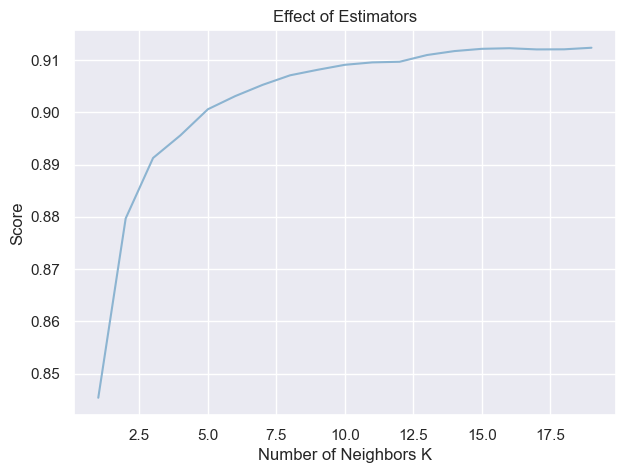

In [55]:
# Try different numbers of n_estimators - this will take a minute or so
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

# Random Forest Model

The RandomForestRegressor class of the sklearn.ensemble library is used to solve regression problems via random forest. The most important parameter of the RandomForestRegressor class is the n_estimators parameter. This parameter defines the number of trees in the random forest.

[(10, 0.9197656952628176),
 (20, 0.9215071418351013),
 (30, 0.9206615208665442),
 (40, 0.9225575903590699),
 (50, 0.9232691889695921),
 (60, 0.9224870635209945),
 (70, 0.9224762263688226),
 (80, 0.9222828364122613),
 (90, 0.9229956543363204),
 (100, 0.9221981828967911),
 (110, 0.9224687553438623),
 (120, 0.9222551014884818),
 (130, 0.9232096478227838),
 (140, 0.9228634542579324),
 (150, 0.9227619952486391),
 (160, 0.922632733928642),
 (170, 0.9226560683655929),
 (180, 0.9235902525071799),
 (190, 0.9233423856922631)]

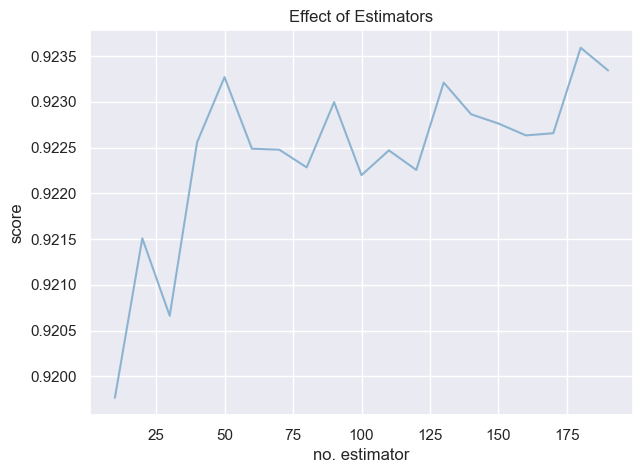

In [56]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

In [83]:
predictions = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [58]:
'Mean Squared Error:', metrics.mean_squared_error(y_test, predictions)

('Mean Squared Error:', 0.19534832930135082)

In [59]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions))

('Root Mean Squared Error:', 0.44198227260983086)